# Application

Comparison between the UQ of the IMV against the UQ of CP under a variety of different models. 

1. Data types: tas, tasmax, pr
2. Metrics: CRPS, marginal calibration (PIT), probabilistic calibration (PIT), dispersion (PIT), sharpness
3. Models: ensemble average, NNGP, CNN, Regression

<!-- Table of comparisons showing that CP has lower CRPS, PIT, etc. scores across a variety of models, projectors, and data types (tas, tasmax, pr) -->

Also include coverage?

Message: Regardless of prediction task, CP has superior UQ, in terms of these metrics, compared with IMV

In [1]:
import os
import gc
import math

# numpy
import numpy as np
import scipy
import numpy.ma as ma
from skimage.transform import resize

# from jax
import jax
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.config import config
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

import haiku as hk
import flax
from flax import linen as nn
import optax

import properscoring as ps

config.update("jax_enable_x64", True)

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
plt.style.use('default')

from matplotlib.gridspec import GridSpec
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from tqdm.notebook import tqdm
from tqdm.notebook import trange

# netCDF
import netCDF4 as nc
import pickle
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import xesmf as xe

In [2]:
from matplotlib.gridspec import GridSpec
from matplotlib import colors
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
def scale_and_split(xtrain, xtest, ytrain, nval = 200, reshape = False):

    ## dimensions
    ntrain = xtrain.shape[0]
    ntest = xtest.shape[0]
    nlat = xtrain.shape[2]
    nlon = xtrain.shape[3]

    ## rescale
    xtrain_mean = np.mean(xtrain, axis = 1)
    xtest_mean = np.mean(xtest, axis = 1)
    xtrain_sd = np.std(xtrain, axis = 1)
    xtest_sd = np.std(xtest, axis = 1)

    xtrain_scaled = (xtrain - xtrain_mean[:,None]) / xtrain_sd[:,None]
    xtest_scaled = (xtest - xtest_mean[:,None]) / xtest_sd[:,None]
    ytrain_scaled = (ytrain - xtrain_mean) / xtrain_sd

    ## convert
    if reshape:
        xtrain_scaled = xtrain_scaled.reshape(ntrain, -1)
        xtest_scaled = xtest_scaled.reshape(ntest, -1)
        ytrain_scaled = ytrain_scaled.reshape(ntrain, -1)

    xtrain_scaled = jnp.array(xtrain_scaled)
    xtest_scaled = jnp.array(xtest_scaled)
    ytrain_scaled = jnp.array(ytrain_scaled)

    xval_scaled = xtrain_scaled[-nval:]
    yval_scaled = ytrain_scaled[-nval:]
    xtrain_scaled = xtrain_scaled[:-nval]
    ytrain_scaled = ytrain_scaled[:-nval]
    
    out = [xtrain_scaled, xval_scaled, xtest_scaled,
            ytrain_scaled, yval_scaled,
            xtrain_mean, xtest_mean, xtrain_sd, xtest_sd]
    return [np.float32(x) for x in out]

def anomalize(xtrain, xtest):
    xtrain_anom = np.zeros_like(xtrain)
    xtest_anom = np.zeros_like(xtest)

    ntrain = xtrain.shape[0]
    ntest = xtest.shape[0]

    monthly_means = np.array([np.mean(xtrain[(12*20):(12*50)][i::12], axis = 0) for i in range(12)])
    for k in trange(ntrain, leave = False):
        xtrain_anom[k] = xtrain[k] - monthly_means[k % 12]

    for k in trange(ntest, leave = False):
        xtest_anom[k] = xtest[k] - monthly_means[k % 12]
    
    return np.array(xtrain_anom), np.array(xtest_anom)

def anomalize_y(ytrain):
    ytrain_anom = np.zeros_like(ytrain)
    ntrain = ytrain.shape[0]

    monthly_means = np.array([np.mean(ytrain[(12*20):(12*50)][i::12], axis = 0) for i in range(12)])
    for k in trange(ntrain, leave = False):
        ytrain_anom[k] = ytrain[k] - monthly_means[k % 12]
    
    return np.array(ytrain_anom)

In [4]:
### model init

def nngp_params(key, depth = 1):

    subkeys = random.split(key, 3 + 2 * (depth - 1))

    base_layer = jnp.array([random.uniform(subkeys[0], minval = 0.75, maxval = 1.25), 
                            random.uniform(subkeys[1], minval = 0.1, maxval = 0.5),
                            random.uniform(subkeys[2], minval = 0.2, maxval = 0.7)])
    base_layer = [tuple(base_layer)]

    return base_layer
parallel_nngp_params = vmap(nngp_params, in_axes=(0, None))


def random_params(key, depth):
    nngp_par = nngp_params(key, depth)
    trend_par = trend_params(key)
    
    return [nngp_par, trend_par]
parallel_params = vmap(random_params, in_axes=(0, None))

@jit
def random_init(params):
    return opt_init(params)
parallel_init = vmap(random_init)

@jit
def param_abs(x):
    return jnp.abs(x)

@jit
def param_select(param_list, i):
    return tree_map(lambda x: x[i], param_list)


### model specification

depth = 7

## nngp functions
def nngp_kernel(params, x, y):
    x = jnp.array(x)
    y = jnp.array(y)
    
    kxx = params[0][1] + params[0][0] * (jnp.dot(x, x.T) / x.shape[0])
    kyy = params[0][1] + params[0][0] * (jnp.dot(y, y.T) / x.shape[0])
    kxy = params[0][1] + params[0][0] * (jnp.dot(x, y.T) / x.shape[0])
    
    for i in range(depth):
        
        ## kxy
        cor = jnp.clip(kxy / jnp.sqrt(kxx * kyy), -1.0 + 1e-16, 1.0 - 1e-16)
        theta = jnp.arccos(cor)
        trig = jnp.sin(theta) + (math.pi - theta) * jnp.cos(theta)
        kxy = params[0][1] + (params[0][0] / (2 * math.pi)) * jnp.sqrt(kxx * kyy) * trig
                
        ## kxx
        kxx = params[0][1] + (params[0][0] / 2) * kxx
    
        ## kyy
        kyy = params[0][1] + (params[0][0] / 2) * kyy
        
    return kxy

nngp_kernel = jit(nngp_kernel)
nngp_cov = jit(vmap(vmap(nngp_kernel, (None, None, 0)), (None, 0, None)))
nngp_var = jit(vmap(nngp_kernel, (None, 0, 0)))


def nngp_predict(params, xtest, xtrain, ytrain):
    n, p = ytrain.shape
        
    k_DD0 = nngp_cov(params, xtrain, xtrain)
    k_DD0 += jnp.diag(jnp.repeat(params[0][2], n))
    prec0 = jnp.linalg.inv(k_DD0)
    
    k_xD0 = nngp_cov(params, xtest, xtrain)
    
    proj0 = jnp.matmul(k_xD0, prec0)
    return jnp.matmul(proj0, ytrain)
nngp_predict = jit(nngp_predict)


def nngp_dist(params, xtest, xtrain, ytrain):
    n, p = ytrain.shape
        
    k_DD0 = nngp_cov(params, xtrain, xtrain)
    k_DD0 += jnp.diag(jnp.repeat(params[0][2], n))
    prec0 = jnp.linalg.inv(k_DD0)
    
    k_xD0 = nngp_cov(params, xtest, xtrain)
    proj0 = jnp.matmul(k_xD0, prec0)
    
    mu = jnp.matmul(proj0, ytrain)
    
    k_xx = nngp_var(params, xtest, xtest)
    sig = k_xx - jnp.sum(proj0 * k_xD0, axis = 1)
    
    return mu, sig
nngp_dist = jit(nngp_dist)


#### loss functions

def compute_lr(pgrad, scale = 2):
    leaves = jnp.array(tree_leaves(pgrad))
    lrs = 10**(-jnp.floor(jnp.log10(jnp.abs(leaves))) - scale)
    return lrs

def weighted_mse(k_inv, ytrain):
    return jnp.matmul(jnp.matmul(ytrain.T, k_inv), ytrain)
weighted_mse = jit(vmap(weighted_mse, (None, 1)))


def full_nll_loss(params, xtrain, ytrain):
    n, p = ytrain.shape

    k = nngp_cov(params, xtrain, xtrain)
    k += jnp.diag(jnp.repeat(params[0][2], n))
    k_inv = jnp.linalg.inv(k)
    
    mse = jnp.sum(weighted_mse(k_inv, ytrain))
    pen = p * jnp.linalg.slogdet(k)[1]
    nor = p/2 * jnp.log(2 * math.pi)
    return (0.5*mse + 0.5*pen + nor) / p
full_grad_loss = jit(grad(full_nll_loss))


def gradient_step(params, xtrain, ytrain):
        
    param, tdef = tree_flatten(params)
    pgrad = tree_flatten(full_grad_loss(params, xtrain, ytrain))[0]
    
    lrs = compute_lr(pgrad, 3)
    param = [a - lr * b for a, b, lr in zip(tree_leaves(param), pgrad, lrs)]

    params = tree_unflatten(tdef, param)
    params = tree_map(param_abs, params)
    return params
gradient_step = jit(gradient_step)
# parallel_gradient_step = vmap(gradient_step, in_axes = (0, None, None))

In [5]:
## regression
def ols(x, y):
    return jnp.matmul(jnp.matmul(jnp.linalg.inv(jnp.matmul(x.T, x)), x.T), y)

ols = jit(ols)
v_ols = vmap(vmap(ols, (2, 1)), (3, 2))
v_ols = jit(v_ols)

def reg_pred(x, beta):
    return jnp.sum(x * beta[None,:,:,:], axis = 1)

reg_pred = jit(reg_pred)

In [6]:
### delta
def delta_pred(xtest, xtrain, ytrain):
    delta = jnp.mean(xtest - xtrain, axis = 1)
    return jnp.median(ytrain + delta, axis = 0)

delta_pred = jit(vmap(delta_pred, (0, None, None)))

# def delta_var(xtest, xtrain, ytrain):
#     delta = jnp.mean(xtest - xtrain, axis = 3)
#     return jnp.std(ytrain + delta, axis = 0)

# delta_var = jit(delta_var)

In [7]:
class encoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(64, kernel_size=(3,3))(x)
        x = nn.selu(x)
        x = nn.Conv(64, kernel_size=(3,3))(x)
        x = nn.selu(x)
        x1 = x
        x = nn.Conv(64, kernel_size=(3,3))(x)
        x = nn.selu(x)
        x = nn.Conv(64, kernel_size=(3,3))(x)
        x = x1 + x
        x = nn.Conv(1, kernel_size=(3,3))(x)
        return x
    
def mse_loss(model, theta, x, y):
    z = model.apply(theta, x).squeeze()
    return jnp.mean((z - y)**2)
grad_mse_loss = jit(grad(mse_loss, argnums=1), static_argnames=['model'])

def optim_update(model, theta, opt_state, x, y):
    grads = grad_mse_loss(model, theta, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    return optax.apply_updates(theta, updates), opt_state
optim_update = jit(optim_update, static_argnames=['model'])

In [8]:
def init_wa(x):
    return [jnp.zeros(x.shape[2:]), jnp.ones(x.shape[1:]) / x.shape[1]]

def weighted_average(theta, x):
    b = theta[0]
    w = theta[1]
    return jnp.sum(x * w[None], axis = 1) + b
    
def wa_loss(theta, x, y):
    z = weighted_average(theta, x).squeeze()
    return jnp.sqrt(jnp.mean((z - y)**2))
grad_wa_loss = jit(grad(wa_loss))

def optim_wa_update(theta, opt_state, x, y):
    grads = grad_wa_loss(theta, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    return optax.apply_updates(theta, updates), opt_state
optim_wa_update = jit(optim_wa_update)

In [9]:
def inf_depth(x, y):
    dist = jnp.max(jnp.abs(y), axis = (1, 2))
    return 1/(1 + dist)
inf_depth = jit(inf_depth)

def global_mmd(x, y):
    dist = jnp.max(jnp.abs(x - y), axis = (1, 2))
    dist = jnp.mean(dist)
    return 1/(1 + dist)
global_mmd = jit(vmap(global_mmd, (None, 0)))

def global_mmd_self(x, y):
    dist = jnp.max(jnp.abs(x - y), axis = (1, 2))
    dist = jnp.mean(jnp.sort(dist)[1:])
    return 1/(1 + dist)
global_mmd_self = jit(vmap(global_mmd_self, (None, 0)))

def field_min(x, y):
    return jnp.min(jnp.array([x, y]))
field_min = jit(vmap(vmap(field_min, (0, 0)), (1, 1)))

def tukey_depth(x, y):
    fx_left = jnp.mean(x < y, axis = 0)
    fx_right = jnp.mean(x > y, axis = 0)
    return jnp.mean(2 * field_min(fx_left, fx_right))
tukey_depth = jit(vmap(tukey_depth, (None, 0)))

def tukey_depth_self(x, y):
    fx_left = jnp.sum(x < y, axis = 0)/(x.shape[0] - 1)
    fx_right = jnp.sum(x > y, axis = 0)/(x.shape[0] - 1)
    return jnp.mean(2 * field_min(fx_left, fx_right))
tukey_depth_self = jit(vmap(tukey_depth_self, (None, 0)))

def conformal_ensemble(resval, depth_fn, alpha):
    nval = resval.shape[0]
    level = np.ceil((1 - alpha) * (nval + 1))/(nval + 1)
    dr1 = 1 - depth_fn(resval, resval)
    q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
    q = (q + np.quantile(dr1, level))/2
    return resval[dr1 < q]

In [10]:
def quantile_interp(model, model_quant, ref_quant):
    return jnp.interp(model, model_quant, ref_quant)
quantile_interp = vmap(quantile_interp, (1, 1, 1))
quantile_interp = vmap(quantile_interp, (1, 1, 1))
quantile_interp = jit(quantile_interp)

def quantile_map(ref, model_hist, model_future):
    ref_quant = jnp.quantile(ref, jnp.linspace(0, 1, 20), axis = 0)
    model_quant = jnp.quantile(model_hist, jnp.linspace(0, 1, 20), axis = 0)
    corrected_model = quantile_interp(model_future, model_quant, ref_quant)
    return jnp.moveaxis(corrected_model, 2, 0)
quantile_map = jit(quantile_map)

In [11]:
def slices(nlat, nlon, seed = 0):
    np.random.seed(seed)
    w = np.random.normal(0,1, [500, nlat*nlon])
    w = w / np.sqrt(np.sum(w**2, axis = 1))[:,None]
    return w

def sw2(x, y, w):
    x = x.reshape(-1, nlat*nlon)
    y = y.reshape(-1, nlat*nlon)
    
    x = x @ w.T
    y = y @ w.T
    
    qx = jnp.quantile(x, jnp.linspace(0, 1, 50), axis = 0)
    qy = jnp.quantile(y, jnp.linspace(0, 1, 50), axis = 0)
    return jnp.mean(jnp.sqrt(jnp.mean((qx - qy)**2, axis = 0)))

sw2 = jit(sw2)


def w2(x, y):
    qx = jnp.quantile(x, jnp.linspace(0.005, 0.995, 100), axis = 0)
    qy = jnp.quantile(y, jnp.linspace(0.005, 0.995, 100), axis = 0)
    return jnp.sqrt(jnp.mean((qx - qy)**2))

w2 = vmap(w2, (1, 1))
w2 = vmap(w2, (1, 1))
w2 = jit(w2)

def crps(ens, y): 
    lb = jnp.min(jnp.array([jnp.min(ens), jnp.min(y)]))
    ub = jnp.max(jnp.array([jnp.max(ens), jnp.max(y)]))
    cdf_a = jnp.array([jnp.mean(x > ens) for x in jnp.linspace(lb, ub, 50)])
    cdf_b = jnp.array([jnp.mean(x > y) for x in jnp.linspace(lb, ub, 50)])
    return jnp.sqrt(jnp.mean((cdf_a - cdf_b)**2))
crps = vmap(crps, (1, 1))
crps = vmap(crps, (1, 1))
crps = jit(crps)

def _pit(ensemble, y):
    pit = jnp.mean(jnp.array(ensemble[None,:] < y[:,None]).squeeze(), axis = 1)
    pit_cdf = jnp.array([jnp.mean(pit < x, axis = 0) for x in np.linspace(0, 1, 50)])
    uni_cdf = jnp.linspace(0, 1, 50)[:,None,None]
    pit_score = jnp.sqrt(jnp.mean((pit_cdf - uni_cdf)**2, axis = 0))
    return pit_score
pit = jit(_pit)

def boot(x):
    n = x.shape[0]
    idx = np.random.choice(n, n, replace = True)
    return x[idx]

def shuffle(x):
    n = x.shape[0]
    idx = np.random.choice(n, n, replace = False)
    return x[idx]

def moving_average(a, n=12):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def mse_weighted(x, y):
    nlat = x.shape[1]
    weight = np.cos(np.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
    weight /= np.mean(weight)
    weight = weight[None,:,None]
    
    return np.sqrt(np.mean((x - y)**2 * weight, axis = (1, 2)))

## tas

In [12]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tas_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tas_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tas'

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = jnp.array(xtrain_anom)
xtest_anom = jnp.array(xtest_anom)
del xtrain_orig, xtest_orig

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

In [13]:
# tas_reanalysis = np.load('../data/saved/t2m_obs.npy')
tas_reanalysis = np.load('../data/tas.npy')
ytrain = tas_reanalysis[:-3]
nlat, nlon = ytrain.shape[1:]
mlat, mlon = xtrain_anom.shape[2:]

grid_in = {"lon": np.linspace(0, 360, nlon), 
           "lat": np.linspace(-90, 90, nlat)}
grid_out = {"lon": np.linspace(0, 360, mlon), 
            "lat": np.linspace(-90, 90, mlat)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
ytrain = regridder(ytrain)
ytrain = np.float32(ytrain)

ytrain_anom = anomalize_y(ytrain)

np.save('../data/tas_lr_anom', ytrain_anom)

  0%|          | 0/1008 [00:00<?, ?it/s]

In [14]:
# grid_in = {"lon": np.linspace(0, 360, nlon), 
#            "lat": np.linspace(-90, 90, nlat)}
# grid_out = {"lon": np.linspace(0, 360, mlon), 
#             "lat": np.linspace(-90, 90, mlat)}
# regridder = xe.Regridder(grid_in, grid_out, "bilinear")
# ytrain = regridder(ytrain)
# ytrain = np.float32(ytrain)

# np.save('../data/tas_lr', ytrain)

In [15]:
save_loc = 'trained_models/tas'

In [16]:
_data = scale_and_split(xtrain_anom, xtest_anom, ytrain_anom)

xtrain_scaled = _data[0]
xval_scaled = _data[1]
xtest_scaled = _data[2]
ytrain_scaled = _data[3]
yval_scaled = _data[4]
xtrain_mean = _data[5]
xtest_mean = _data[6]
xtrain_sd = _data[7]
xtest_sd = _data[8]

ntrain = xtrain_scaled.shape[0]
nval = xval_scaled.shape[0]
ntest = xtest_scaled.shape[0]

del _data

xtrain_scaled = jnp.array(xtrain_scaled)
xval_scaled = jnp.array(xval_scaled)
xtest_scaled = jnp.array(xtest_scaled)
ytrain_scaled = jnp.array(ytrain_scaled)
yval_scaled = jnp.array(yval_scaled)
xtrain_mean = jnp.array(xtrain_mean)
xtest_mean = jnp.array(xtest_mean)
xtrain_sd = jnp.array(xtrain_sd)
xtest_sd = jnp.array(xtest_sd)

In [17]:
#### Ens average
yval_hat = np.mean(xval_scaled, axis = 1)
ytest_hat = np.mean(xtest_scaled, axis = 1)
# yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
# ytest_hat = xtest_sd * ytest_hat + xtest_mean
np.save(save_loc + f'/yval_ens', yval_hat)
np.save(save_loc + f'/ytest_ens', ytest_hat)

#### Delta
yval_hat = jnp.vstack([delta_pred(xval_scaled[n:(n+10)], xtrain_scaled, ytrain_scaled) for n in trange(nval//10, leave = False)])
ytest_hat = jnp.vstack([delta_pred(xtest_scaled[n:(n+12)], xtrain_scaled, ytrain_scaled) for n in trange(ntest//12, leave = False)])
# yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
# ytest_hat = xtest_sd * ytest_hat + xtest_mean
np.save(save_loc + f'/yval_delta', yval_hat)
np.save(save_loc + f'/ytest_delta', ytest_hat)

#### linear regression
beta = v_ols(xtrain_scaled, ytrain_scaled)
beta = jnp.nan_to_num(beta)
beta = jnp.moveaxis(beta, (0, 1, 2), (2, 1, 0))
yval_hat = reg_pred(xval_scaled, beta)
ytest_hat = reg_pred(xtest_scaled, beta)
# yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
# ytest_hat = xtest_sd * ytest_hat + xtest_mean
np.save(save_loc + f'/yval_lm', yval_hat)
np.save(save_loc + f'/ytest_lm', ytest_hat)

#### NNGP
key = random.PRNGKey(1023)
params = nngp_params(key, depth)
for _ in trange(300, leave = False):
    params = gradient_step(params, xtrain_scaled.reshape(ntrain, -1), ytrain_scaled.reshape(ntrain, -1))

yval_hat = nngp_predict(params, 
                        xval_scaled.reshape(nval, -1), 
                        xtrain_scaled.reshape(ntrain, -1), 
                        ytrain_scaled.reshape(ntrain, -1))
yval_hat = yval_hat.reshape(-1, mlat, mlon)
ytest_hat = nngp_predict(params, 
                        xtest_scaled.reshape(ntest, -1), 
                        xtrain_scaled.reshape(ntrain, -1), 
                        ytrain_scaled.reshape(ntrain, -1))
ytest_hat = ytest_hat.reshape(-1, mlat, mlon)
# yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
# ytest_hat = xtest_sd * ytest_hat + xtest_mean
np.save(save_loc + f'/yval_nngp', yval_hat)
np.save(save_loc + f'/ytest_nngp', ytest_hat)

#### WA
theta = init_wa(xtrain_scaled)
opt_init, opt_update = optax.adam(1e-1)
opt_state = opt_init(theta)

for i in trange(1000, leave = False):
    theta, opt_state = optim_wa_update(theta, opt_state, xtrain_scaled, ytrain_scaled)

yval_hat = weighted_average(theta, xval_scaled)
ytest_hat = weighted_average(theta, xtest_scaled)
# yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
# ytest_hat = xtest_sd * ytest_hat + xtest_mean

yval_hat = np.float32(yval_hat)
ytest_hat = np.float32(ytest_hat)

np.save(save_loc + f'/yval_wa', yval_hat)
np.save(save_loc + f'/ytest_wa', ytest_hat)

#### CNN
xtrain_scaled = jnp.moveaxis(xtrain_scaled, 1, 3)
xval_scaled = jnp.moveaxis(xval_scaled, 1, 3)
xtest_scaled = jnp.moveaxis(xtest_scaled, 1, 3)
key = random.PRNGKey(1023)
enc = encoder()
theta = enc.init(key, xtrain_scaled[0:5])
opt_init, opt_update = optax.adam(1e-3)
opt_state = opt_init(theta)

for i in trange(2000, leave = False):
    idx = np.random.choice(ntrain, 32)
    theta, opt_state = optim_update(enc, theta, opt_state, xtrain_scaled[idx], ytrain_scaled[idx])

yval_hat = enc.apply(theta, xval_scaled).squeeze()
ytest_hat = np.vstack([enc.apply(theta, xtest_scaled[(30*i):(30*(i+1))]) for i in range(ntest//30 + 1)]).squeeze()
# yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
# ytest_hat = xtest_sd * ytest_hat + xtest_mean
np.save(save_loc + f'/yval_cnn1', yval_hat)
np.save(save_loc + f'/ytest_cnn1', ytest_hat)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

## pr

In [14]:
xhist_tas = pickle.load(open('../data/xhist_pr_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_pr_hr.pkl', 'rb'))

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0]
ntest = xtest_orig.shape[0]

mlat, mlon = xtrain_orig.shape[2:]

xtrain_orig = np.log(np.abs(xtrain_orig) + 1e-3)
xtest_orig = np.log(np.abs(xtest_orig) + 1e-3)

In [15]:
# tas_reanalysis = np.load('../data/saved/t2m_obs.npy')
pr_reanalysis = np.load('../data/pr.npy')
ytrain_orig = np.float32(pr_reanalysis[:-3])
nlat, nlon = ytrain_orig.shape[1:]
mlat, mlon = xtrain_orig.shape[2:]

ytrain_orig = np.log(np.abs(ytrain_orig) + 1e-3)

grid_in = {"lon": np.linspace(0, 360, nlon), 
           "lat": np.linspace(-90, 90, nlat)}
grid_out = {"lon": np.linspace(0, 360, mlon),
            "lat": np.linspace(-90, 90, mlat)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
ytrain_orig = regridder(ytrain_orig)
ytrain_orig = np.float32(ytrain_orig)

ytrain_anom = anomalize_y(ytrain_orig)
np.save('../data/pr_lr_anom', ytrain_anom)

del ytrain_orig

  0%|          | 0/1008 [00:00<?, ?it/s]

In [16]:
xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom, xtest_anom = np.float32(xtrain_anom), np.float32(xtest_anom)

ytrain_anom = np.load('../data/pr_lr_anom.npy')
xtrain_anom = jnp.array(xtrain_anom)
xtest_anom = jnp.array(xtest_anom)
del xtrain_orig, xtest_orig


# np.save('../data/pr_lr_anom', ytrain_anom)

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

In [18]:
save_loc = 'trained_models/pr'

In [19]:
xtrain_anom.dtype, xtest_anom.dtype, ytrain_anom.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

In [20]:
_data = scale_and_split(xtrain_anom, xtest_anom, ytrain_anom, nval=400)

xtrain_scaled = _data[0]
xval_scaled = _data[1]
xtest_scaled = _data[2]
ytrain_scaled = _data[3]
yval_scaled = _data[4]
xtrain_mean = _data[5]
xtest_mean = _data[6]
xtrain_sd = _data[7]
xtest_sd = _data[8]

ntrain = xtrain_scaled.shape[0]
nval = xval_scaled.shape[0]
ntest = xtest_scaled.shape[0]

del _data

In [26]:
xtrain_scaled = jnp.array(xtrain_scaled)
xval_scaled = jnp.array(xval_scaled)
xtest_scaled = jnp.array(xtest_scaled)
ytrain_scaled = jnp.array(ytrain_scaled)
yval_scaled = jnp.array(yval_scaled)
xtrain_mean = jnp.array(xtrain_mean)
xtest_mean = jnp.array(xtest_mean)
xtrain_sd = jnp.array(xtrain_sd)
xtest_sd = jnp.array(xtest_sd)

In [27]:
#### Ens average
yval_hat = np.mean(xval_scaled, axis = 1)
ytest_hat = np.mean(xtest_scaled, axis = 1)
# yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
# ytest_hat = xtest_sd * ytest_hat + xtest_mean
np.save(save_loc + f'/yval_ens', yval_hat)
np.save(save_loc + f'/ytest_ens', ytest_hat)

del yval_hat, ytest_hat

#### Delta
yval_hat = jnp.vstack([jax.block_until_ready(delta_pred(xval_scaled[n:(n+10)], xtrain_scaled, ytrain_scaled)) for n in trange(nval//10, leave = False)])
ytest_hat = jnp.vstack([jax.block_until_ready(delta_pred(xtest_scaled[n:(n+12)], xtrain_scaled, ytrain_scaled)) for n in trange(ntest//12, leave = False)])
# yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
# ytest_hat = xtest_sd * ytest_hat + xtest_mean
np.save(save_loc + f'/yval_delta', yval_hat)
np.save(save_loc + f'/ytest_delta', ytest_hat)

del yval_hat, ytest_hat

#### linear regression
beta = v_ols(xtrain_scaled, ytrain_scaled)
beta = jnp.nan_to_num(beta)
beta = jnp.moveaxis(beta, (0, 1, 2), (2, 1, 0))
yval_hat = reg_pred(xval_scaled, beta)
ytest_hat = reg_pred(xtest_scaled, beta)
# yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
# ytest_hat = xtest_sd * ytest_hat + xtest_mean
np.save(save_loc + f'/yval_lm', yval_hat)
np.save(save_loc + f'/ytest_lm', ytest_hat)

del yval_hat, ytest_hat

#### NNGP
key = random.PRNGKey(1023)
params = nngp_params(key, depth)
for _ in trange(300, leave = False):
    params = gradient_step(params, xtrain_scaled.reshape(ntrain, -1), ytrain_scaled.reshape(ntrain, -1))

yval_hat = nngp_predict(params, 
                        xval_scaled.reshape(nval, -1), 
                        xtrain_scaled.reshape(ntrain, -1), 
                        ytrain_scaled.reshape(ntrain, -1))
yval_hat = yval_hat.reshape(-1, mlat, mlon)
ytest_hat = nngp_predict(params, 
                        xtest_scaled.reshape(ntest, -1), 
                        xtrain_scaled.reshape(ntrain, -1), 
                        ytrain_scaled.reshape(ntrain, -1))
ytest_hat = ytest_hat.reshape(-1, mlat, mlon)
# yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
# ytest_hat = xtest_sd * ytest_hat + xtest_mean
np.save(save_loc + f'/yval_nngp', yval_hat)
np.save(save_loc + f'/ytest_nngp', ytest_hat)

del yval_hat, ytest_hat

#### WA
theta = init_wa(xtrain_scaled)
opt_init, opt_update = optax.adam(1e-1)
opt_state = opt_init(theta)

for i in trange(1000, leave = False):
    theta, opt_state = optim_wa_update(theta, opt_state, xtrain_scaled, ytrain_scaled)

yval_hat = weighted_average(theta, xval_scaled)
ytest_hat = weighted_average(theta, xtest_scaled)
# yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
# ytest_hat = xtest_sd * ytest_hat + xtest_mean

yval_hat = np.float32(yval_hat)
ytest_hat = np.float32(ytest_hat)

np.save(save_loc + f'/yval_wa', yval_hat)
np.save(save_loc + f'/ytest_wa', ytest_hat)

del yval_hat, ytest_hat

#### CNN
xtrain_scaled = jnp.moveaxis(xtrain_scaled, 1, 3)
xval_scaled = jnp.moveaxis(xval_scaled, 1, 3)
xtest_scaled = jnp.moveaxis(xtest_scaled, 1, 3)
key = random.PRNGKey(1023)
enc = encoder()
theta = enc.init(key, xtrain_scaled[0:5])
opt_init, opt_update = optax.adam(1e-3)
opt_state = opt_init(theta)

for i in trange(2000, leave = False):
    idx = np.random.choice(ntrain, 32)
    theta, opt_state = optim_update(enc, theta, opt_state, xtrain_scaled[idx], ytrain_scaled[idx])

yval_hat = enc.apply(theta, xval_scaled).squeeze()
ytest_hat = np.vstack([enc.apply(theta, xtest_scaled[(30*i):(30*(i+1))]) for i in range(ntest//30 + 1)]).squeeze()
# yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
# ytest_hat = xtest_sd * ytest_hat + xtest_mean
np.save(save_loc + f'/yval_cnn1', yval_hat)
np.save(save_loc + f'/ytest_cnn1', ytest_hat)

del yval_hat, ytest_hat

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2024-07-09 11:43:53.426207: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 12.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-09 11:43:53.539394: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 12.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-09 11:43:55.988694: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 14.63GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-09 11:43:58.564843: W external/tsl/tsl/framework/bfc_allocator.cc:296] All

In [41]:
#### NNGP
key = random.PRNGKey(1023)
params = nngp_params(key, depth)

for _ in trange(300, leave = False):
    params = gradient_step(params, xtrain_scaled.reshape(ntrain, -1), ytrain_scaled.reshape(ntrain, -1))

  0%|          | 0/300 [00:00<?, ?it/s]

In [106]:
#### WA
theta = init_wa(xtrain)
opt_init, opt_update = optax.adam(1e-1)
opt_state = opt_init(theta)

for i in trange(1000, leave = False):
    theta, opt_state = optim_wa_update(theta, opt_state, xtrain_scaled, ytrain_scaled)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [111]:
yval_wa = weighted_average(theta, xval_scaled)
yval_wa = xtrain_sd[-nval:] * yval_wa + xtrain_mean[-nval:]

ytest_wa = weighted_average(theta, xtest_scaled)
ytest_wa = xtest_sd * ytest_wa + xtest_mean

In [112]:
yval_nngp = nngp_predict(params, 
                        xval_scaled.reshape(nval, -1), 
                        xtrain_scaled.reshape(ntrain, -1), 
                        ytrain_scaled.reshape(ntrain, -1))
yval_nngp = yval_nngp.reshape(-1, mlat, mlon)
yval_nngp = xtrain_sd[-nval:] * yval_nngp + xtrain_mean[-nval:]

ytest_nngp = nngp_predict(params, 
                        xtest_scaled.reshape(ntest, -1), 
                        xtrain_scaled.reshape(ntrain, -1), 
                        ytrain_scaled.reshape(ntrain, -1))
ytest_nngp = ytest_nngp.reshape(-1, mlat, mlon)
ytest_nngp = xtest_sd * ytest_nngp + xtest_mean

In [114]:
yval = xtrain_sd[-nval:] * yval_scaled + xtrain_mean[-nval:]

In [116]:
res_nngp = (yval - yval_nngp).reshape(-1, mlat, mlon)

alpha = 0.1
level = np.ceil((1 - alpha) * (nval + 1))/(nval + 1)
dr1 = 1 - global_mmd_self(res_nngp, res_nngp)
q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
q = (q + np.quantile(dr1, level))/2
conf_nngp = res_nngp[dr1 < q]

In [ ]:
# yearly IMV
xtest2 = np.mean(xtest.reshape(76, 12, 31, -1), axis = (1, 3))
xtest2.shape

In [ ]:
# yearly CONF WA
xtest2 = np.mean(xtest.reshape(76, 12, 31, -1), axis = (1, 3))
xtest2.shape

In [79]:
### yearly nngp 
ytest_hat2 = []

for i in trange(76):
    ytest_confi = ytest_hat[(12*i):(12*(i+1)),None] + conf_ens1[None,:]
    ytest_hat2.append(np.mean(ytest_confi, axis = (0, 2, 3)))

  0%|          | 0/76 [00:00<?, ?it/s]

In [103]:
xtest2 = np.mean(xtest.reshape(76, 12, 31, -1), axis = (1, 3))
xtest2.shape

(76, 31)

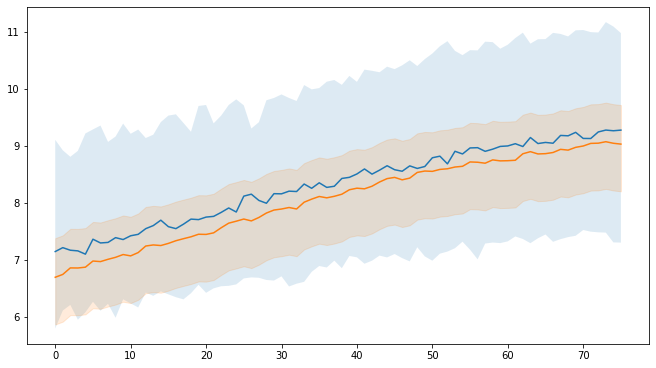

In [104]:
fig, ax = plt.subplots(1, 1, constrained_layout = True, figsize = (9, 5))

ts = np.arange(76)
plt.plot(ts, np.median(xtest2, axis = 1))
plt.fill_between(ts, np.min(xtest2, axis = 1), np.max(xtest2, axis = 1), alpha = 0.15)

plt.plot(ts, np.median(ytest_hat2, axis = 1), c = 'C1')
plt.fill_between(ts, np.min(ytest_hat2, axis = 1), np.max(ytest_hat2, axis = 1), alpha = 0.15, color = 'C1')

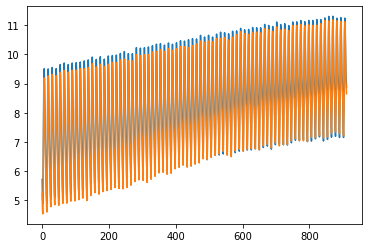

In [60]:
plt.plot(np.mean(xtest, axis = (1, 2, 3)))
plt.plot(np.mean(ytest_hat, axis = (1, 2)))

In [148]:
nmod = 31

imv_ens = xtest[-nval2:]
imv_ens = imv_ens - np.mean(imv_ens, axis = 1)[:,None]
imv_ens2 = np.zeros([nval2, nmod, nlat, nlon])
for i in trange(nval2):
    for j in range(nmod):
        imv_ens2[i,j] = resize(imv_ens[i,j], (nlat, nlon))

  0%|          | 0/120 [00:00<?, ?it/s]

In [149]:
metrics(imv_ens2[:,1:], restest)

(Array(1.32959093, dtype=float64),
 Array(0.61914921, dtype=float64),
 Array(14.0993277, dtype=float64),
 Array(0.01908116, dtype=float64))

In [150]:
metrics(conf_ens[1:], restest)

(Array(1.32959093, dtype=float64),
 Array(0.58035048, dtype=float64),
 Array(13.92004469, dtype=float64),
 Array(0.00985539, dtype=float64))

In [151]:
conf_ens.shape

(181, 360, 720)

In [198]:
def sw2(x, y, w):
    x = x.reshape(-1, nlat*nlon)
    y = y.reshape(-1, nlat*nlon)
    
    x = x @ w.T
    y = y @ w.T
    
    qx = jnp.quantile(x, jnp.linspace(0, 1, 50), axis = 0)
    qy = jnp.quantile(y, jnp.linspace(0, 1, 50), axis = 0)
    return jnp.mean(jnp.sqrt(jnp.mean((qx - qy)**2, axis = 0)))

sw2 = jit(sw2)

In [203]:
w = np.random.normal(0,1, [500, nlat*nlon])
w = w / np.sqrt(np.sum(w**2, axis = 1))[:,None]

In [204]:
sw2(conf_ens, restest, w)

Array(0.45417552, dtype=float64)

In [208]:
sw2(imv_ens2.reshape(-1, nlat,nlon), restest, w)

Array(1.65677385, dtype=float64)

In [209]:
ycal_hat = xtrain_mean_scaled[-nval1:-nval2]

resval = ycal - ycal_hat
dr1 = global_mmd(resval, resval)
qn = np.sort(dr1)[int(np.ceil((1-0.1) * ((nval1-nval2) + 1)))]
conf_ens = resval[dr1 < qn]
del resval

In [210]:
nmod = 31

imv_ens = xtest[-nval2:]
imv_ens = imv_ens - np.mean(imv_ens, axis = 1)[:,None]
imv_ens2 = np.zeros([nval2, nmod, nlat, nlon])
for i in trange(nval2):
    for j in range(nmod):
        imv_ens2[i,j] = resize(imv_ens[i,j], (nlat, nlon))

  0%|          | 0/120 [00:00<?, ?it/s]

In [211]:
ytest_hat = xtrain_mean_scaled[-nval2:]
restest = ytest - ytest_hat

In [212]:
metrics(imv_ens2[:,1:], restest)

(Array(2.01155286, dtype=float64),
 Array(0.90549465, dtype=float64),
 Array(23.34729632, dtype=float64),
 Array(0.05207497, dtype=float64))

In [213]:
metrics(conf_ens[1:], restest)

(Array(2.01155286, dtype=float64),
 Array(0.67048416, dtype=float64),
 Array(14.84867898, dtype=float64),
 Array(0.00704101, dtype=float64))

In [214]:
sw2(conf_ens, restest, w)

Array(0.47513694, dtype=float64)

In [215]:
sw2(imv_ens2.reshape(-1, nlat,nlon), restest, w)

Array(1.94992421, dtype=float64)

## fieldwise sd plots

In [19]:
xhist_tas = pickle.load(open('../data/xhist_tas.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tas.pkl', 'rb'))

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

xtrain = xtrain_orig
xtest = xtest_orig

ntrain = xtrain.shape[0]
ntest = xtest.shape[0]

In [20]:
xtrain.shape

(1008, 31, 80, 120)

In [21]:
# tas_reanalysis = np.load('../data/saved/t2m_obs.npy')
tas_reanalysis = np.load('../data/tas.npy')
ytrain = tas_reanalysis[:-3]
nlat, nlon = ytrain.shape[1:]
ytrain.shape

(1008, 721, 1440)

In [22]:
## rescale
xtrain_mean = np.mean(xtrain, axis = 1)
xtest_mean = np.mean(xtest, axis = 1)
xtrain_sd = np.std(xtrain, axis = 1)
xtest_sd = np.std(xtest, axis = 1)

xtrain_scaled = (xtrain - xtrain_mean[:,None]) / xtrain_sd[:,None]
xtest_scaled = (xtest - xtest_mean[:,None]) / xtest_sd[:,None]
# ytrain_scaled = (ytrain - xtrain_mean) / xtrain_sd
# ytest_scaled = (ytest - xtest_mean) / xtest_sd

In [23]:
xtrain_mean_scaled = np.moveaxis(xtrain_mean, (0, 1, 2), (2, 0, 1))
xtrain_mean_scaled = resize(xtrain_mean_scaled, (721, 1440))
xtrain_mean_scaled = np.moveaxis(xtrain_mean_scaled, (2, 0, 1), (0, 1, 2))

xtrain_sd_scaled = np.moveaxis(xtrain_sd, (0, 1, 2), (2, 0, 1))
xtrain_sd_scaled = resize(xtrain_sd_scaled, (721, 1440))
xtrain_sd_scaled = np.moveaxis(xtrain_sd_scaled, (2, 0, 1), (0, 1, 2))

In [24]:
ytrain_scaled = (ytrain - xtrain_mean_scaled) / xtrain_sd_scaled

In [25]:
nval = 200

xtrain_scaled = xtrain_scaled.reshape(ntrain, -1)
ytrain_scaled = ytrain_scaled.reshape(ntrain, -1)

xcal_scaled = xtrain_scaled[-nval:]
ycal_scaled = ytrain_scaled[-nval:]

xtrain_scaled = xtrain_scaled[:-nval]
ytrain_scaled = ytrain_scaled[:-nval]

In [41]:
key = random.PRNGKey(1023)
params = nngp_params(key, depth)

for _ in trange(300, leave = False):
    params = gradient_step(params, xtrain_scaled, ytrain_scaled)

  0%|          | 0/300 [00:00<?, ?it/s]

In [26]:
params = [(jnp.array(1.59383992), jnp.array(0.80550929), jnp.array(0.25048987))]

In [43]:
params

[(Array(1.59383992, dtype=float64),
  Array(0.80550929, dtype=float64),
  Array(0.25048987, dtype=float64))]

In [28]:
# set conf alpha
alpha = 0.1
nval = 200
level = 1 - np.ceil((1-0.1) * (nval + 1))/(nval + 1)

In [29]:
ycal_hat = nngp_predict(params, xcal_scaled, xtrain_scaled, ytrain_scaled)
ycal_hat = ycal_hat.reshape(-1, nlat, nlon)
ycal_hat = xtrain_sd_scaled[-nval:] * ycal_hat + xtrain_mean_scaled[-nval:]

In [30]:
ycal = ytrain[-nval:]

In [31]:
resval = ycal - ycal_hat
dr1 = global_mmd(resval, resval)
qn = np.sort(dr1)[int(np.ceil((1-0.1) * (nval + 1)))]
conf_ens = resval[dr1 < qn]
del resval

In [32]:
conf_sd = np.std(conf_ens, axis = 0).reshape(nlat, nlon)

In [33]:
ens_sd = np.std(xtrain[-nval:].reshape(-1, 80, 120), axis = 0)

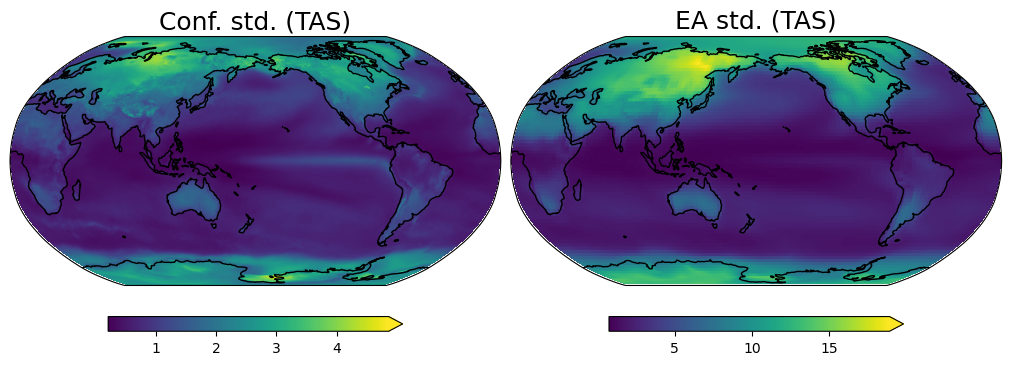

In [37]:
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

color_map = 'viridis'

fig = plt.figure(constrained_layout = True, figsize = (10, 6))
gs = GridSpec(1, 2, figure = fig)

## conformal sd
conf_sd = np.std(conf_ens, axis = 0).reshape(nlat, nlon)
ax = plt.subplot(gs[0, 0], projection = plot_crs)
im = ax.imshow(conf_sd, transform = data_crs, cmap = color_map)
ax.coastlines()
ax.set_title("Conf. std. (TAS)", fontsize = 18)


cbar = plt.colorbar(im, ax=ax, location = 'bottom', extend = 'max', shrink = 0.6)
cbar.ax.locator_params(nbins=7)

## ensemble sd
ax = plt.subplot(gs[0, 1], projection = plot_crs)
im = ax.imshow(ens_sd, transform = data_crs, cmap = color_map)
ax.coastlines()

ax.set_title("EA std. (TAS)", fontsize = 18)
cbar = plt.colorbar(im, ax=ax, location = 'bottom', extend = 'max', shrink = 0.6)
cbar.ax.locator_params(nbins=7)
plt.show()

In [96]:
# ens_sd = np.mean(np.std(xtrain[-200:].reshape(200, -1, 80, 120), axis = 1), axis = 0)
# data_crs = ccrs.PlateCarree(central_longitude=180)
# plot_crs = ccrs.Robinson(central_longitude=180)

# fig = plt.figure(constrained_layout = True, figsize = (10, 6))
# gs = GridSpec(1, 1, figure = fig)

# ax = plt.subplot(gs[0, 0], projection = plot_crs)
# im = ax.imshow(ens_sd, transform = data_crs)
# ax.coastlines()
# # ax.colorbar(shrink = 0.7)

# plt.title("Conf. standard deviation (TAS)", fontsize = 25)
# plt.colorbar(im, ax=ax, location = 'bottom', extend = 'max', shrink = 0.6)
# plt.show()

In [26]:
def conformal_ensemble(res_val, depth_fn, alpha = 0.05, rng = 0):
    dval = depth_fn(res_val, res_val)
    qval = np.quantile(dval, alpha)
    
    ens = res_val[dval > qval]
    ens = jax.random.permutation(jax.random.PRNGKey(rng), ens, 0)
    return ens

In [27]:
ycal_hat = nngp_predict(params, xcal_scaled, xtrain_scaled, ytrain_scaled)
ycal_hat = ycal_hat.reshape(-1, nlat, nlon)
ycal_hat = xtrain_sd_scaled[-200:] * ycal_hat + xtrain_mean_scaled[-200:]
# ycal_hat = ycal_hat.reshape(200, -1)

In [28]:
ycal = ycal_scaled.reshape(-1, nlat, nlon)
ycal = xtrain_sd_scaled[-200:] * ycal + xtrain_mean_scaled[-200:]
# ycal = ycal_hat.reshape(200, -1)

In [29]:
# del xtrain_mean_scaled, xtrain_sd_scaled

## Ensemble variation

Plot showing the variation purely within the ensemble. Does not include prediction variation

In [30]:
conf_ens = np.array(conformal_ensemble(ycal - ycal_hat, local_mmd_self, alpha = 0.1))

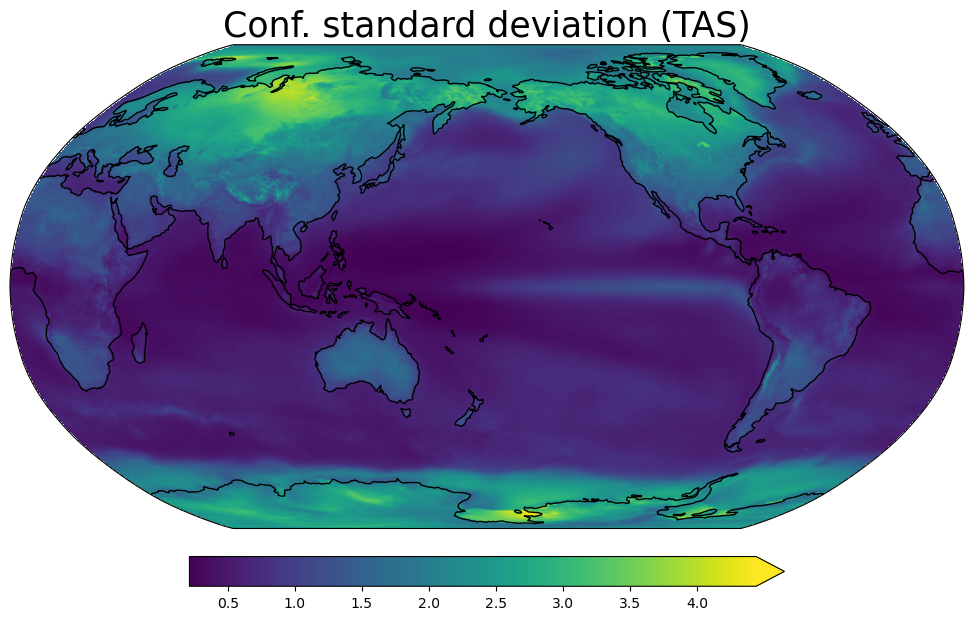

In [31]:
conf_sd = np.std(conf_ens, axis = 0).reshape(nlat, nlon)
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

fig = plt.figure(constrained_layout = True, figsize = (10, 6))
gs = GridSpec(1, 1, figure = fig)

ax = plt.subplot(gs[0, 0], projection = plot_crs)
im = ax.imshow(conf_sd, transform = data_crs)
ax.coastlines()
# ax.colorbar(shrink = 0.7)

plt.title("Conf. standard deviation (TAS)", fontsize = 25)
plt.colorbar(im, ax=ax, location = 'bottom', extend = 'max', shrink = 0.6)
plt.show()

In [33]:
xtest_scaled = xtest_scaled.reshape(ntest, -1)

In [34]:
# xtest_mean_scaled = np.moveaxis(xtest_mean, (0, 1, 2), (2, 0, 1))
# xtest_mean_scaled = resize(xtest_mean_scaled, (721, 1440))
# xtest_mean_scaled = np.moveaxis(xtest_mean_scaled, (2, 0, 1), (0, 1, 2))

# xtest_sd_scaled = np.moveaxis(xtest_sd, (0, 1, 2), (2, 0, 1))
# xtest_sd_scaled = resize(xtest_sd_scaled, (721, 1440))
# xtest_sd_scaled = np.moveaxis(xtest_sd_scaled, (2, 0, 1), (0, 1, 2))

## Prediction variation

Compare the average spatial variation (2-4 time blocks) compared with the ensemble mean.

In [35]:
ytest_hat = []
for i in trange(0, ntest, 60):
    
    xtest_mean_scaled = np.moveaxis(xtest_mean[i:(i+60)], (0, 1, 2), (2, 0, 1))
    xtest_mean_scaled = resize(xtest_mean_scaled, (721, 1440))
    xtest_mean_scaled = np.moveaxis(xtest_mean_scaled, (2, 0, 1), (0, 1, 2))

    xtest_sd_scaled = np.moveaxis(xtest_sd[i:(i+60)], (0, 1, 2), (2, 0, 1))
    xtest_sd_scaled = resize(xtest_sd_scaled, (721, 1440))
    xtest_sd_scaled = np.moveaxis(xtest_sd_scaled, (2, 0, 1), (0, 1, 2))
    
    _hat = nngp_predict(params, xtest_scaled[i:(i+60)], xtrain_scaled, ytrain_scaled)
    _hat = np.array(_hat)
    _hat = _hat.reshape(-1, nlat, nlon)
    _hat = xtest_sd_scaled * _hat + xtest_mean_scaled
    ytest_hat.append(_hat)
    
    del _hat, xtest_sd_scaled, xtest_mean_scaled

  0%|          | 0/16 [00:00<?, ?it/s]

In [36]:
ytest_hat = np.vstack(ytest_hat)
n = ytest_hat.shape[0]
n

948

In [ ]:
block1_est = []
for i in trange(300):
    _est = np.array(ytest_hat[i] + conf_ens)
    block1_est.append(_est)

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
_est = ytest_hat[0] + conf_ens
_est.shape

## Aggregate variation

In [28]:
yearly_est = np.zeros([n, 180])
for i in trange(n):
    _est = ytest_hat[i] + conf_ens
#     _est = xtest_sd_scaled[i] * _est + xtest_mean_scaled[i]
    yearly_est[i] = np.mean(_est, axis = (1, 2))

  0%|          | 0/948 [00:00<?, ?it/s]

In [37]:
pr_reanalysis = np.load('../nngp_cmip/data/saved/t2m_obs.npy')
ytrain = pr_reanalysis[:-7]

In [38]:
xtrain.shape, ytrain.shape

((852, 31, 80, 120), (852, 721, 1440))

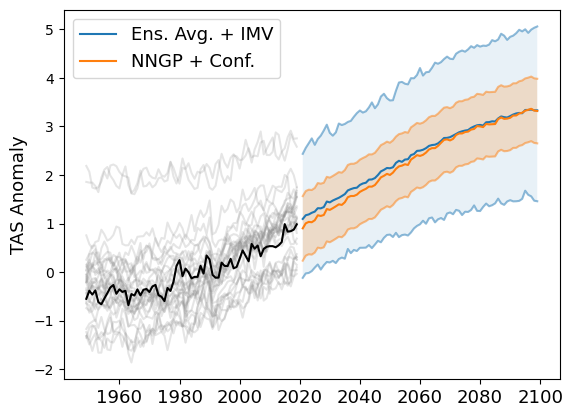

In [39]:
x0 = np.arange(1949, 2020)
x1 = np.arange(2021, 2100)

anom = np.mean(ytrain)

xtrain_mod = np.mean(xtrain.reshape(ntrain, 31, -1), axis = 2)
# xtrain_mod = np.delete(xtrain_mod, 6, 1)
# xcal_mod = np.mean(xcal.reshape(ncal, 31, -1), axis = 2)
# xcal_mod = np.delete(xcal_mod, 6, 1)
xhist_mod = np.mean(xtrain_mod.reshape(-1, 12, 31), axis = 1) - anom

plt.plot(x0, xhist_mod, c = 'grey', alpha = 0.2)

yhist_mean = np.mean(np.mean(ytrain, axis = (1, 2)).reshape(-1, 12), axis = 1) - anom
plt.plot(x0, yhist_mean, c = 'black')

yearly_mu = np.mean(np.mean(yearly_est, axis = 1).reshape(-1, 12), axis = 1) - anom
yearly_ub = np.mean(np.max(yearly_est, axis = 1).reshape(-1, 12), axis = 1) - anom
yearly_lb = np.mean(np.min(yearly_est, axis = 1).reshape(-1, 12), axis = 1) - anom

xtest_mu = np.mean(np.mean(np.mean(xtest[0:n], axis = (2, 3)), axis = 1).reshape(-1, 12), axis = 1) - anom
xtest_ub = np.mean(np.quantile(np.mean(xtest[0:n], axis = (2, 3)), 0.95, axis = 1).reshape(-1, 12), axis = 1) - anom
xtest_lb = np.mean(np.quantile(np.mean(xtest[0:n], axis = (2, 3)), 0.05, axis = 1).reshape(-1, 12), axis = 1) - anom


plt.plot(x1, xtest_mu, c = 'C0', alpha = 1, label = 'Ens. Avg. + IMV')
plt.plot(x1, xtest_ub, c = 'C0', alpha = 0.5)
plt.plot(x1, xtest_lb, c = 'C0', alpha = 0.5)
plt.fill_between(x1, xtest_lb, xtest_ub, alpha = 0.1)

plt.plot(x1, yearly_mu, c = 'C1', alpha = 1, label = 'NNGP + Conf.')
plt.plot(x1, yearly_ub, c = 'C1', alpha = 0.5)
plt.plot(x1, yearly_lb, c = 'C1', alpha = 0.5)
plt.fill_between(x1, yearly_lb, yearly_ub, alpha = 0.2)

plt.ylabel('TAS Anomaly', fontsize = 13)
plt.xticks(fontsize = 13)
plt.legend(fontsize = 13)
plt.show()

In [9]:
def conformal_ensemble(res_val, depth_fn, alpha = 0.05, rng = 0):
    dval = depth_fn(res_val, res_val)
    qval = np.quantile(dval, alpha)
    
    ens = res_val[dval > qval]
    ens = jax.random.permutation(jax.random.PRNGKey(rng), ens, 0)
    return ens

In [10]:
xhist_tas = pickle.load(open('data/xhist_pr.pkl', 'rb'))
xrcp_tas = pickle.load(open('data/xrcp_pr.pkl', 'rb'))

n = (2015 - 1950) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:72]], axis = 0)
xtest_orig = xrcp_tas[72:]

xtrain = xtrain_orig
xtest = xtest_orig

ntrain = xtrain.shape[0]
ntest = xtest.shape[0]

In [18]:
# tas_reanalysis = np.load('../data/saved/t2m_obs.npy')
pr_reanalysis = np.load('../nngp_cmip/data/saved/pr_obs.npz.npy')
ytrain = pr_reanalysis[:-9]
nlat, nlon = ytrain.shape[1:]

In [20]:
xtrain = np.log(np.abs(xtrain) + 1e-3)
ytrain = np.log(np.abs(ytrain) + 1e-3)

In [13]:
## rescale
xtrain_mean = np.mean(xtrain, axis = 1)
xtest_mean = np.mean(xtest, axis = 1)
xtrain_sd = np.std(xtrain, axis = 1)
xtest_sd = np.std(xtest, axis = 1)

xtrain_scaled = (xtrain - xtrain_mean[:,None]) / xtrain_sd[:,None]
xtest_scaled = (xtest - xtest_mean[:,None]) / xtest_sd[:,None]
# ytrain_scaled = (ytrain - xtrain_mean) / xtrain_sd
# ytest_scaled = (ytest - xtest_mean) / xtest_sd

In [14]:
xtrain_mean_scaled = np.moveaxis(xtrain_mean, (0, 1, 2), (2, 0, 1))
xtrain_mean_scaled = resize(xtrain_mean_scaled, (721, 1440))
xtrain_mean_scaled = np.moveaxis(xtrain_mean_scaled, (2, 0, 1), (0, 1, 2))

xtrain_sd_scaled = np.moveaxis(xtrain_sd, (0, 1, 2), (2, 0, 1))
xtrain_sd_scaled = resize(xtrain_sd_scaled, (721, 1440))
xtrain_sd_scaled = np.moveaxis(xtrain_sd_scaled, (2, 0, 1), (0, 1, 2))

In [21]:
ytrain_scaled = (ytrain - xtrain_mean_scaled) / xtrain_sd_scaled

In [22]:
xtrain_scaled = xtrain_scaled.reshape(ntrain, -1)
ytrain_scaled = ytrain_scaled.reshape(ntrain, -1)

xcal_scaled = xtrain_scaled[-200:]
ycal_scaled = ytrain_scaled[-200:]

xtrain_scaled = xtrain_scaled[:-200]
ytrain_scaled = ytrain_scaled[:-200]

In [23]:
key = random.PRNGKey(1023)
params = nngp_params(key, depth)

for _ in trange(300, leave = False):
    params = gradient_step(params, xtrain_scaled, ytrain_scaled)

  0%|          | 0/300 [00:00<?, ?it/s]

In [29]:
params

[(Array(1.84855222, dtype=float64),
  Array(0.65672544, dtype=float64),
  Array(0.12052672, dtype=float64))]

In [24]:
ycal_hat = nngp_predict(params, xcal_scaled, xtrain_scaled, ytrain_scaled)
ycal_hat = ycal_hat.reshape(-1, nlat, nlon)
ycal_hat = xtrain_sd_scaled[-200:] * ycal_hat + xtrain_mean_scaled[-200:]

ycal = ycal_scaled.reshape(-1, nlat, nlon)
ycal = xtrain_sd_scaled[-200:] * ycal + xtrain_mean_scaled[-200:]

In [25]:
conf_ens = np.array(conformal_ensemble(ycal - ycal_hat, local_mmd_self, alpha = 0.1))

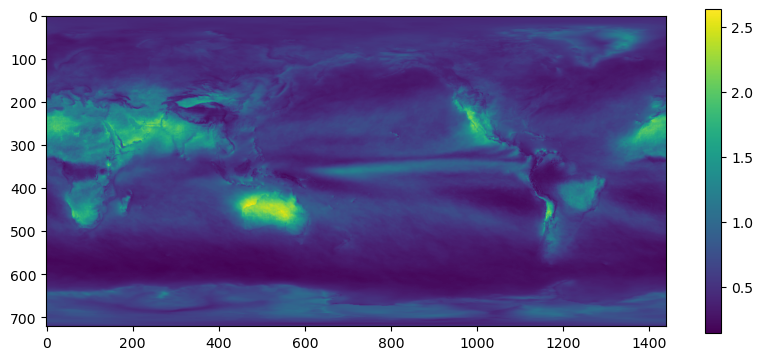

In [26]:
plt.figure(figsize = (10, 6))
plt.imshow(np.std(conf_ens, axis = 0).reshape(nlat, nlon))
plt.colorbar(shrink = 0.7)

In [27]:
xtest_scaled = xtest_scaled.reshape(ntest, -1)

In [28]:
xtest_mean_scaled = np.moveaxis(xtest_mean, (0, 1, 2), (2, 0, 1))
xtest_mean_scaled = resize(xtest_mean_scaled, (721, 1440))
xtest_mean_scaled = np.moveaxis(xtest_mean_scaled, (2, 0, 1), (0, 1, 2))

xtest_sd_scaled = np.moveaxis(xtest_sd, (0, 1, 2), (2, 0, 1))
xtest_sd_scaled = resize(xtest_sd_scaled, (721, 1440))
xtest_sd_scaled = np.moveaxis(xtest_sd_scaled, (2, 0, 1), (0, 1, 2))

In [ ]:
ytest_hat = []
for i in trange(0, ntest, 60):
    _hat = nngp_predict(params, xtest_scaled[i:(i+60)], xtrain_scaled, ytrain_scaled)
    _hat = np.array(_hat)
    _hat = _hat.reshape(-1, nlat, nlon)
    _hat = xtest_sd_scaled[i:(i+60)] * _hat + xtest_mean_scaled[i:(i+60)]
    ytest_hat.append(_hat)
    del _hat

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
ytest_hat = np.vstack(ytest_hat)
n = ytest_hat.shape[0]

In [ ]:
yearly_est = np.zeros([n, 180])
for i in trange(n):
    _est = ytest_hat[i] + conf_ens
#     _est = xtest_sd_scaled[i] * _est + xtest_mean_scaled[i]
    yearly_est[i] = np.mean(_est, axis = (1, 2))

In [ ]:
x0 = np.arange(1949, 2020)
x1 = np.arange(2021, 2100)

anom = np.mean(ytrain)

yhist_mean = np.mean(np.mean(ytrain, axis = (1, 2)).reshape(-1, 12), axis = 1) - anom
plt.plot(x0, yhist_mean, c = 'black')

yearly_mu = np.mean(np.mean(yearly_est, axis = 1).reshape(-1, 12), axis = 1) - anom
yearly_ub = np.mean(np.max(yearly_est, axis = 1).reshape(-1, 12), axis = 1) - anom
yearly_lb = np.mean(np.min(yearly_est, axis = 1).reshape(-1, 12), axis = 1) - anom

xtest_mu = np.mean(np.mean(np.mean(xtest[0:n], axis = (2, 3)), axis = 1).reshape(-1, 12), axis = 1) - anom
xtest_ub = np.mean(np.quantile(np.mean(xtest[0:n], axis = (2, 3)), 0.95, axis = 1).reshape(-1, 12), axis = 1) - anom
xtest_lb = np.mean(np.quantile(np.mean(xtest[0:n], axis = (2, 3)), 0.05, axis = 1).reshape(-1, 12), axis = 1) - anom


plt.plot(x1, xtest_mu, c = 'C0', alpha = 1, label = 'Ens. Avg. + IMV')
plt.plot(x1, xtest_ub, c = 'C0', alpha = 0.5)
plt.plot(x1, xtest_lb, c = 'C0', alpha = 0.5)
plt.fill_between(x1, xtest_lb, xtest_ub, alpha = 0.1)

plt.plot(x1, yearly_mu, c = 'C1', alpha = 1, label = 'NNGP + Conf.')
plt.plot(x1, yearly_ub, c = 'C1', alpha = 0.5)
plt.plot(x1, yearly_lb, c = 'C1', alpha = 0.5)
plt.fill_between(x1, yearly_lb, yearly_ub, alpha = 0.2)

plt.ylabel('TAS Anomaly', fontsize = 13)
plt.xticks(fontsize = 13)
plt.legend(fontsize = 13)
plt.show()

In [207]:
# x = np.arange(30)
# yearly_mu = np.mean(np.mean(yearly_est, axis = 1).reshape(-1, 12), axis = 1)
# yearly_ub = np.mean(np.max(yearly_est, axis = 1).reshape(-1, 12), axis = 1)
# yearly_lb = np.mean(np.min(yearly_est, axis = 1).reshape(-1, 12), axis = 1)

# xtest_mu = np.mean(np.mean(np.mean(xtest[0:360], axis = (2, 3)), axis = 1).reshape(-1, 12), axis = 1)
# xtest_ub = np.mean(np.quantile(np.mean(xtest[0:360], axis = (2, 3)), 0.95, axis = 1).reshape(-1, 12), axis = 1)
# xtest_lb = np.mean(np.quantile(np.mean(xtest[0:360], axis = (2, 3)), 0.05, axis = 1).reshape(-1, 12), axis = 1)

# plt.plot(yearly_mu, c = 'C0', alpha = 1)
# plt.plot(yearly_ub, c = 'C0', alpha = 0.5)
# plt.plot(yearly_lb, c = 'C0', alpha = 0.5)
# plt.fill_between(x, yearly_lb, yearly_ub, alpha = 0.2)

# plt.plot(xtest_mu, c = 'C1', alpha = 1)
# plt.plot(xtest_ub, c = 'C1', alpha = 0.5)
# plt.plot(xtest_lb, c = 'C1', alpha = 0.5)
# plt.fill_between(x, xtest_lb, xtest_ub, alpha = 0.2)
# plt.show()

In [11]:
from matplotlib.gridspec import GridSpec
from matplotlib import colors
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

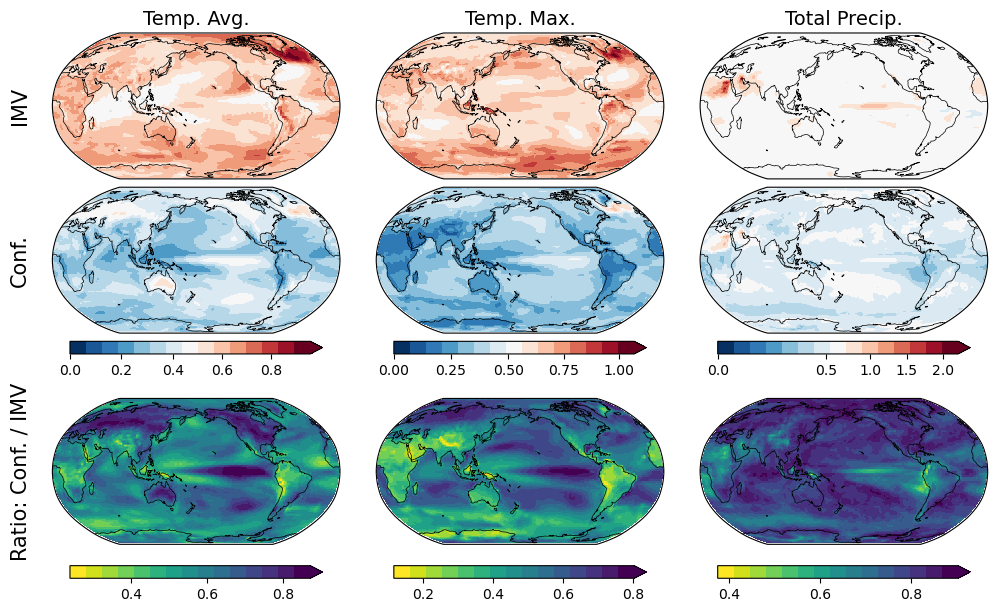

In [12]:
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

fig = plt.figure(constrained_layout = True, figsize = (10, 6))
gs = GridSpec(3, 4, width_ratios = [0.05, 1, 1, 1], figure = fig)


# side labels
ax1 = plt.subplot(gs[0, 0])
ax1.axis('off')
ax1.text(0.0, 0.5, 'IMV', fontsize=15, va='center', rotation='vertical')

ax2 = plt.subplot(gs[1, 0])
ax2.axis('off')
ax2.text(0.0, 0.5, 'Conf.', fontsize=15, va='center', rotation='vertical')

ax3 = plt.subplot(gs[2, 0])
ax3.axis('off')
ax3.text(0.0, 0.5, 'Ratio: Conf. / IMV', fontsize=15, va='center', rotation='vertical')


cmap12 = plt.get_cmap('RdBu_r', 15)
cmap3  = plt.get_cmap('viridis_r', 15)

for j in range(1, 4):
    ens_metrics1 = np.mean(all_metrics[j-1][:,2,1], axis = 0)
    ens_metrics2 = np.mean(all_metrics[j-1][:,3,1], axis = 0)
    
    vmin = 0
    vcenter = np.median([ens_metrics1, ens_metrics2])
    vmax = np.max([ens_metrics1, ens_metrics2]) 
    
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    
    ax1 = plt.subplot(gs[0, j], projection = plot_crs)
    ax2 = plt.subplot(gs[1, j], projection = plot_crs)
    ax3 = plt.subplot(gs[2, j], projection = plot_crs)
    
    im1 = ax1.imshow(ens_metrics1, transform = data_crs, cmap = cmap12, norm = divnorm)
    im2 = ax2.imshow(ens_metrics2, transform = data_crs, cmap = cmap12, norm = divnorm)
    im3 = ax3.imshow(ens_metrics2/ens_metrics1, transform = data_crs, cmap = cmap3)
    
    ax1.coastlines(lw = 0.5)
    ax2.coastlines(lw = 0.5)
    ax3.coastlines(lw = 0.5)
    
    ax1.set_title('' + all_vars[j-1], fontsize = 14)
    
    plt.colorbar(im2, ax=ax2, location = 'bottom', extend = 'max', shrink = 0.8)
    plt.colorbar(im3, ax=ax3, location = 'bottom', extend = 'max', shrink = 0.8)